In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np

In [4]:
__file__ = 'C:/Users/antie/Documents/Pole_recherche/Tsunami'

In [3]:
__file__ = 'C:/Users/Gilles/CS/cours/PoleProjet/FormationRecherche/Tsunami/TP/sceance4/Tsunami'

In [4]:
import os

print(os.getcwd())
os.chdir(__file__)
print(os.getcwd())

c:\Users\Gilles\CS\cours\PoleProjet\FormationRecherche\Tsunami\TP\sceance4\Tsunami\differentiate
C:\Users\Gilles\CS\cours\PoleProjet\FormationRecherche\Tsunami\TP\sceance4\Tsunami


In [5]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

## Create the model

In [12]:
# To fix weights or biases of layers
class ConstantTensorInitializer(tf.keras.initializers.Initializer):
  """Initializes tensors to `t`."""

  def __init__(self, t):
    self.t = t

  def __call__(self, shape, dtype=None):
    return self.t

  def get_config(self):
    # A constraint config is a Python dictionary (JSON-serializable) that can be used to reinstantiate the same object.
    return {'t': self.t}

class ConstantTensorConstraint(tf.keras.constraints.Constraint):
  """Constrains tensors to `t`."""

  def __init__(self, t):
    self.t = t

  def __call__(self, w):
    return self.t

  def get_config(self):
    return {'t': self.t}


# t could be :
t = tf.ones((3,4))
print(t)

t1 = tf.eye(3,4)
print(t1)

tf.Tensor(
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]], shape=(3, 4), dtype=float32)


In [18]:
# méthode API Sequential
multilayer_perceptron = keras.models.Sequential([
  keras.layers.Input(shape=(2)),
  #keras.layers.GaussianNoise(stddev=1e-3),
  keras.layers.Dense(20,activation='elu'),
  keras.layers.Dense(20,activation='elu'),
  keras.layers.Dense(1,use_bias=False)
])


In [19]:
multilayer_perceptron.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                60        
                                                                 
 dense_5 (Dense)             (None, 20)                420       
                                                                 
 dense_6 (Dense)             (None, 1)                 20        
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


In [20]:
print(len(multilayer_perceptron.trainable_variables))

5


In [55]:
learning_rate = 0.01
training_steps = 1000
batch_size = 10000
display_step = 100

optimizer = tf.optimizers.Adam(lr=learning_rate)

C:\Users\Gilles\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
import Polynomials.polynome4students_v2 as Pstud

frontier_coords = Pstud._set_coords_rectangle(1,1,40)

F_xpy_real = Pstud._set_polynome_xpy_numpy_real(frontier_coords)
F_expxpy_real = Pstud._set_polynome_expxpy_numpy_real(frontier_coords)
F_sinxpy_real = Pstud._set_polynome_sinxpy_numpy_real(frontier_coords)

F_xpy_cmplx = Pstud._set_polynome_xpy_numpy_cmplx(frontier_coords)

F facile :

In [ ]:
import sympy as sm
x,y = sm.symbols('x,y')

def expr_dummy_F():
    return x*(1-x)*y*(1-y)

expr_dummy_F = x*(1-x)*y*(1-y)
dexpr_dummy_F_dx = ...


In [56]:

# Universal Approximator
def g(x):
  # F_x = Pstud._eval_polynome_numpy(F_xpy_real,x[0,0],x[0,1])
  N_x = multilayer_perceptron(x)
  return N_x

# Given EDO
def f(X):
  return tf.sin(np.pi*X[:,0])*tf.sin(np.pi*X[:,1])


def boundary_conditions(X):
  return 0


def residual(du_dxx,du_dyy,f_ind):
  return du_dxx+du_dyy+f_ind


def differentiate(model,x):
  with tf.GradientTape(persistent=True) as tape:
    x1, x2 = x[:,0:1], x[:,1:2]
    tape.watch(x1)
    tape.watch(x2)
    u = model(tf.stack([x1[:,0], x2[:,0]], axis=1))
    du_dx = tape.gradient(u,x1)
    du_dy = tape.gradient(u,x2)
  du_dxx = tape.gradient(du_dx,x1) 
  du_dyy = tape.gradient(du_dy,x2)
  return du_dxx,du_dyy




X = np.linspace(0,1,100)
Y = np.linspace(0,1,100)
coords = [tf.constant([x,y],dtype=DTYPE) for x in X for y in Y]
boundary_coords = tf.convert_to_tensor([tf.constant([x,y],dtype=DTYPE) for x in [0,1] for y in Y ] + [tf.constant([x,y],dtype=DTYPE) for y in [0,1] for x in X ])  

print(boundary_coords)

# Custom loss function to approximate the derivatives

# method 1 : mini-batch gradient descent + (loss = MSE + MSE on all boundary) 
def custom_loss_1():
  indices = np.random.randint(len(coords),size=batch_size)
  sample_coords = [coords[i] for i in indices]

  tf_sample_coords = tf.convert_to_tensor(sample_coords)

  dg_dxx,dg_dyy = differentiate(g,tf_sample_coords)
  # print(dg_dxx,dg_dyy)
  f_r = tf.reshape(f(tf_sample_coords),[batch_size,1])
  # print(tf.concat([dg_dxx+dg_dyy,f_r],axis=1))
  # print('dg_dxx\n', dg_dxx)
  # print('f_r \n',f_r)
  res = residual(dg_dxx,dg_dyy,f_r)
  # choose an L2 norm ? Could we find other losses ?
  # print('concat;\n', tf.concat([dg_dxx+dg_dyy,-f_r],axis=1))
  loss = tf.reduce_mean(tf.square(res)) + tf.reduce_mean(tf.square(g(boundary_coords)-boundary_conditions(boundary_coords)))
  # print('loss :', loss)
  return loss

tf.Tensor(
[[0.         0.        ]
 [0.         0.01010101]
 [0.         0.02020202]
 [0.         0.03030303]
 [0.         0.04040404]
 [0.         0.05050505]
 [0.         0.06060606]
 [0.         0.07070707]
 [0.         0.08080808]
 [0.         0.09090909]
 [0.         0.1010101 ]
 [0.         0.11111111]
 [0.         0.12121212]
 [0.         0.13131313]
 [0.         0.14141414]
 [0.         0.15151516]
 [0.         0.16161616]
 [0.         0.17171717]
 [0.         0.18181819]
 [0.         0.1919192 ]
 [0.         0.2020202 ]
 [0.         0.21212122]
 [0.         0.22222222]
 [0.         0.23232323]
 [0.         0.24242425]
 [0.         0.25252524]
 [0.         0.26262626]
 [0.         0.27272728]
 [0.         0.28282827]
 [0.         0.2929293 ]
 [0.         0.3030303 ]
 [0.         0.3131313 ]
 [0.         0.32323232]
 [0.         0.33333334]
 [0.         0.34343433]
 [0.         0.35353535]
 [0.         0.36363637]
 [0.         0.37373737]
 [0.         0.3838384 ]
 [0.         0

In [116]:
indices = np.random.randint(len(coords),size=batch_size)
sample_coords = [coords[i] for i in indices]

tf_sample_coords = tf.convert_to_tensor(sample_coords)
print(tf_sample_coords)

tf.Tensor(
[[0.969697   0.42424244]
 [0.8080808  0.959596  ]], shape=(2, 2), dtype=float32)


## Train the model

epoch: 0
loss: 0.154128 
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoc

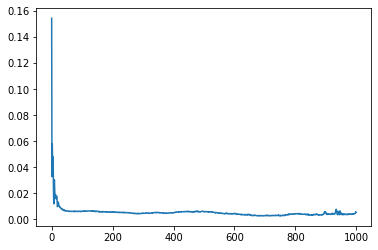

In [57]:
def train_step():
  with tf.GradientTape() as tape:
      loss = custom_loss()
  trainable_variables=multilayer_perceptron.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))


# Training the Model:

all_losses = []
for i in range(training_steps):
  print ('epoch:',i)
  train_step()
  loss = custom_loss_1()
  if i % display_step == 0:
    print("loss: %f " % (loss))
  all_losses.append(loss)

plt.plot(np.arange(0,training_steps),all_losses)
plt.show()

## Compare to the true solution

In [38]:
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

In [65]:
def true_function(X):
    return tf.sin(np.pi*X[:,0])*tf.sin(np.pi*X[:,1])/(2*np.pi**2)

def false_appro_function(X):
    return tf.sin(np.pi*X[:,0])*tf.sin(np.pi*X[:,1])/(np.pi**2)+1

In [66]:
tf_coords = tf.convert_to_tensor(coords)
# print(tf.reshape(tf_coords,[100,100,2]))
# print(tf.reshape(tf_coords,[100,100,2])[-1])

true_values = tf.reshape(true_function(tf_coords),[100,100]).numpy()
appro_values = tf.reshape(g(tf_coords),[100,100]).numpy()
error = np.abs(true_values-appro_values)

print(np.max(error))
print(error.shape)

0.021429896
(100, 100)


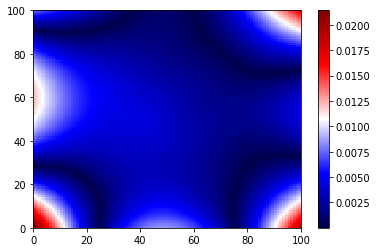

In [67]:
seismic = cm.get_cmap('seismic', 1024)
# visualize with the new_inferno colormaps
plt.pcolormesh(error, cmap = seismic)
plt.colorbar()




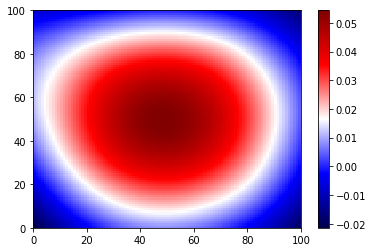

In [61]:
plt.pcolormesh(appro_values, cmap = seismic)
plt.colorbar()

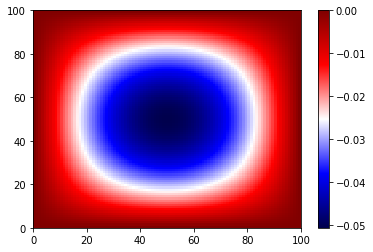

In [62]:
plt.pcolormesh(true_values, cmap = seismic)
plt.colorbar()

## Save the model

In [21]:
multilayer_perceptron.save('differentiate/model_EDP_2D.h5')

## Load the model

In [18]:
multilayer_perceptron = keras.models.load_model('differentiate/model_EDP_2D.h5')

# Questions 

Quelle architecture ? 

Comment éviter l'overfitting ?

Comment exploiter les avantages de l'IA ?

Choix de l'optimizer + regularizer ? + Implémentation ?

Implémentation de système d'EDP à plusieurs inconnues (étant des fonctions bien sûr) ?

Plus rapide ? Comment enlever les boucles `for` ? => batch_gradient_descent ?

Besoin de batch_normalization ? + autres hyperparamètres ?

# Idées

Ajout de bruit en entrée contre l'overfitting 

Une sortie par inconnue